# NLP - Análise de sentimentos

### Bibliotecas básicas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

from nltk import tokenize
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [3]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud, ImageColorGenerator
from unicodedata import normalize

%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['font.size'] = 14

### Carregando os dados

In [5]:
resenha = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alura/imdb-reviews-pt-br.csv')
print(resenha.shape)
resenha.sample(2)

(49459, 4)


,id,text_en,text_pt,sentiment
22580,22582,Throughout the world the unmistakable imprint ...,"Em todo o mundo, a marca inconfundível da amer...",pos
43606,43608,"""Hot Millions"" is a delightful comedy that is ...","""Hot Millions"" é uma comédia deliciosa que se ...",pos


In [6]:
print('Resenha negativa: ')
resenha['text_pt'][189]

Resenha negativa: 


'Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolta inacreditável que o filme faz - passando de um extremamente mau filme "Formas de vida alienígenas habitam a terra", com um filme que tenta espalhar um arquicristiano "O dia do julgamento está próximo, buscar Jesus ou queimar por toda a eternidade em as dívidas ardentes do inferno "mensagem - deixou-me atordoado depois de ter sido atormentado por 85 minutos. Até mesmo os cristãos religiosos devem se envergonhar ou ficar furiosos ao ver suas crenças postadas dessa maneira. Eu não sabia o que fazer comigo quando assisti a atuação horrível que poderia ter sido realizada por crianças de 7 anos de idade. Simplesmente repugnante. Eu não sou cristão nem muito religioso. Mas se eu estivesse, não teria mais medo do Inferno. Rich Christiano mostrou ser algo muito pior.'

In [7]:
print('Resenha positiva: ')
resenha['text_pt'][49002]

Resenha positiva: 


'Crescendo em Nova York no final dos anos 80 e início dos anos 90, posso dizer pessoalmente que este é um dos documentários mais importantes feitos para cobrir esse lugar neste período de tempo. Não Madonna não veio com a idéia de Voguing, mas é de onde ela tirou! Em vez de combater a violência uns dos outros ou em brigas de gato, o voguing permitia que as pessoas "lutassem" dentro dos confins de tudo, menos que tocassem umas às outras, o que justificaria uma desqualificação automática. Vendo este tipo de extraordinariamente talentosas / bem orquestradas "jogadas" nos clubes foi nada menos do que espetacular e todos os grandes nomes de antigamente estão aqui ... Pepper La Beija, Paris Duprée, Xtragavaganza, etc. ..tudo comemorado nos gostos de peças de época como a música de Malcom McLarens "Deep in Vogue" ... não importava quem você era, ou de onde você era porque quando você passava por aquelas portas nesse "reino mágico" de De certa forma, você se tornou parte de algo maior que você

In [8]:
resenha['sentiment'].value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

### Enconder das targets

In [9]:
classificacao = resenha['sentiment'].replace(['neg', 'pos'], [0, 1])
resenha['classificacao'] = classificacao
resenha.sample(2)

,id,text_en,text_pt,sentiment,classificacao
25757,25759,TV movie about an ancient Egyptian curse broug...,Filme de TV sobre uma antiga maldição egípcia ...,neg,0
2524,2526,I had to write a review for this movie based o...,Eu tive que escrever uma resenha para este fil...,neg,0


### Funções utilitárias

In [33]:
def classificar_texto(texto, coluna_texto, coluna_classificacao, model):
  vetorizar = CountVectorizer(max_features=50, stop_words=STOP_WORDS)
  bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
  X_train, X_test, y_train, y_test = train_test_split(bag_of_words, texto[coluna_classificacao], random_state=42)
  clf = model
  clf.fit(X_train, y_train)
  return clf.score(X_test, y_test)


def plot_word_cloud(texto, coluna_texto, pos_or_neg=None):
  if pos_or_neg == 'pos':
    texto = texto.query('sentiment=="pos"')
  elif pos_or_neg == 'neg':
    texto = texto.query('sentiment=="neg"')
  else:
    texto = texto
  todas_as_palavras = ' '.join([texto for texto in texto[coluna_texto]])
  nuvem_de_palavras = WordCloud(background_color='black', 
                                width=800, height=500, 
                                max_font_size=110, 
                                collocations=False).generate(todas_as_palavras)
  plt.figure(figsize=(10, 7))
  plt.imshow(nuvem_de_palavras, interpolation='bilinear')
  plt.axis('off')
  plt.show()


def plot_frequency(texto, coluna_texto, quantidade):
  todas_as_palavras = ' '.join([texto for texto in texto[coluna_texto]])
  tokens = tokenize.WhitespaceTokenizer().tokenize(todas_as_palavras)
  frequencia = nltk.FreqDist(tokens)
  df_frequencia = pd.DataFrame({'Palavras': list(frequencia.keys()), 'Frequencia': list(frequencia.values())})
  df_frequencia = df_frequencia.nlargest(columns='Frequencia', n=quantidade)
  plt.figure(figsize=(12, 8))
  ax = sns.barplot(data=df_frequencia.nlargest(columns='Frequencia', n=10), x='Palavras', y='Frequencia', color='k')
  ax.set(ylabel='Contagem')
  plt.title('Palavras mais frequentes', y=1.05, fontsize=16)
  plt.show()


def removeSpecialCharacters(text):
    punctuationRegex = re.compile(r'[^0-9a-zA-Z +_-]')
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    text = punctuationRegex.sub(' ', text)    
    return text


def remove_stopwords(text):
  return ' '.join(word for word in text.split() if word not in STOP_WORDS)


def stemmer_words(text):
  stemmer =  nltk.RSLPStemmer()
  return ' '.join(stemmer.stem(word) for word in text.split())

def cleaning(text):
    text = text.lower()
    text = text.replace('-', ' ')
    cleanedText = remove_stopwords(text)
    cleanedText = removeSpecialCharacters(cleanedText)
    return cleanedText


def classificar_texto_tfidf(texto, coluna_texto, coluna_classificacao, model, n=(1, 2), ngram=False):
  if ngram:
    tfidf = TfidfVectorizer(ngram_range=n, stop_words=STOP_WORDS)
  else:
    tfidf = TfidfVectorizer(max_features=50, stop_words=STOP_WORDS)
  bag_of_words_tfidf = tfidf.fit_transform(texto[coluna_texto])
  X_train, X_test, y_train, y_test = train_test_split(bag_of_words_tfidf, texto[coluna_classificacao], random_state=42)
  clf = model
  clf.fit(X_train, y_train)
  return clf.score(X_test, y_test), clf.coef_, tfidf.get_feature_names()

### Pré-processamento: Removendo stopwords

In [11]:
resenha['cleaning_text'] = resenha['text_pt'].apply(cleaning)
resenha.sample()

,id,text_en,text_pt,sentiment,classificacao,cleaning_text
26101,26103,One of the serious potential environmental cos...,Um dos graves custos ambientais potenciais da ...,neg,0,graves custos ambientais potenciais maioria op...


### Classificação de sentimentos

In [12]:
print(classificar_texto(resenha, 'cleaning_text', 'classificacao', LogisticRegression(solver='lbfgs')))

0.6879094217549535


### Nuvens de palavras

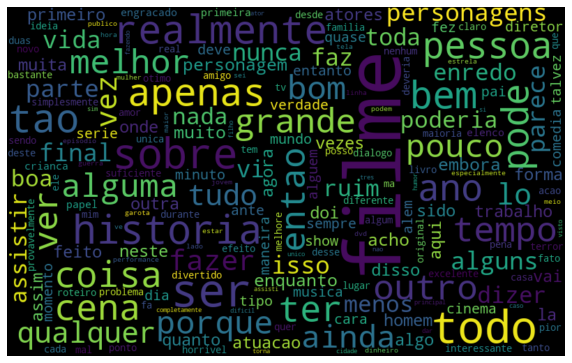

In [13]:
plot_word_cloud(resenha, 'cleaning_text')

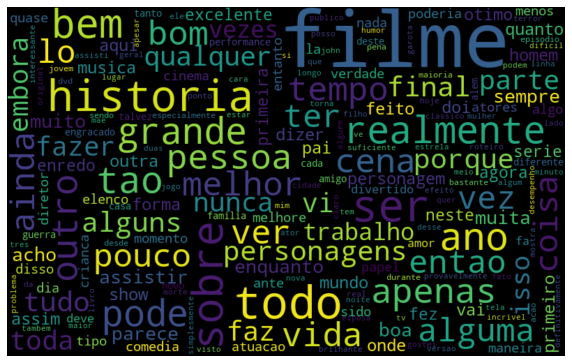

In [14]:
plot_word_cloud(resenha, 'cleaning_text', 'pos')

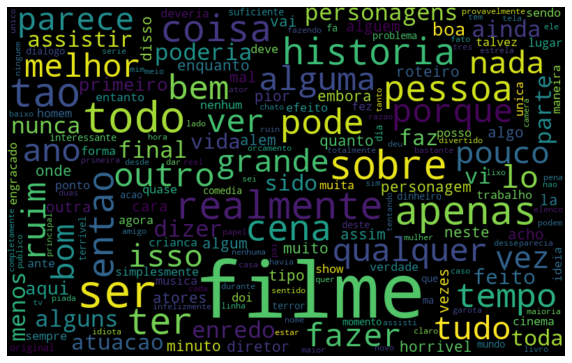

In [15]:
plot_word_cloud(resenha, 'cleaning_text', 'neg')

### Frequência das palavras

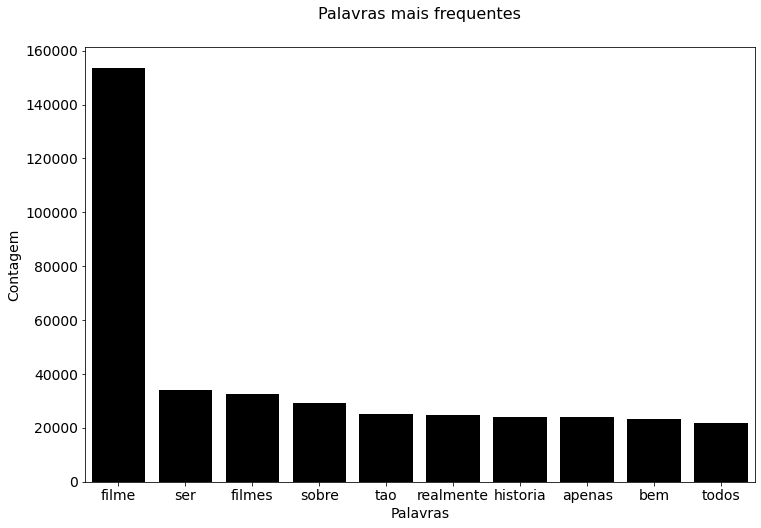

In [16]:
plot_frequency(resenha, 'cleaning_text', 10)

### Stemmer

In [17]:
resenha['stemmer_text'] = resenha['cleaning_text'].apply(stemmer_words)
resenha.sample()

,id,text_en,text_pt,sentiment,classificacao,cleaning_text,stemmer_text
41725,41727,I watched this film a few times in the 90s and...,Eu assisti a esse filme algumas vezes nos anos...,pos,1,assisti filme algumas vezes anos 90 quase queb...,assist film algum vez ano 90 quas quebr lad ri...


In [18]:
print(classificar_texto(resenha, 'stemmer_text', 'classificacao', LogisticRegression(solver='lbfgs')))

0.6971289931257582


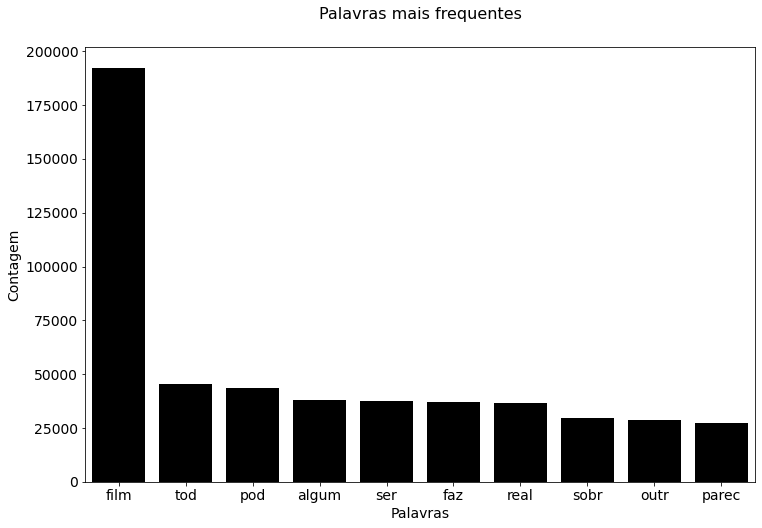

In [19]:
plot_frequency(resenha, 'stemmer_text', 10)

### TF-IDF

In [22]:
classificar_texto_tfidf(resenha, 'text_pt', 'classificacao', LogisticRegression(solver='lbfgs'))

0.6876668014557218

In [30]:
classificar_texto_tfidf(resenha, 'stemmer_text', 'classificacao', LogisticRegression(solver='lbfgs'))

0.6964820056611403

### N-Grams

In [34]:
score, coef, features_names = classificar_texto_tfidf(resenha, 'stemmer_text', 'classificacao',
                                                      LogisticRegression(solver='lbfgs'), ngram=True)
print(score)

0.8859684593610999


### Negativos e positivos de acordo com o modelo

In [35]:
pesos = pd.DataFrame(coef.T, index=features_names)
pesos.nlargest(10, 0)

,0
otim,9.860252
excel,8.996919
perfeit,6.915616
maravilh,6.280173
favorit,5.895722
incri,5.733877
divert,5.419409
brilh,4.858991
ador,4.559175
hoj,4.491810


In [36]:
pesos.nsmallest(10, 0)

,0
ruim,-11.786871
pi,-11.426023
horri,-9.699489
terri,-8.376401
nad,-7.584673
chat,-7.511562
parec,-6.635292
nenhum,-6.364399
tent,-5.763430
mal,-5.721629
